## Use case 2: distribution of certificates across repository types (R)

Observants of the repository landscape are interested in conducting a multivariate analysis of certification status and type of research data repositories.

Research data repositories are diverse. The re3data Metadata Schema tries to account for that, resulting in rich and detailed metadata that can be accessed via the re3data API.

### Step 1: load packages

The package **httr** includes the HTTP method GET, which will be used to request data from the re3data API. Responses from the redata API are returned in XML. **xml2** includes functions for working with XML, for example parsing or extracting content of specific elements. **dplyr** and **tidyr** offer useful functions for data manipulation and reshaping. **ggplot2** is a package for data visualization.

If necessary, install the packages before loading them.

In [1]:
#install.packages("htttr")
#install.packages("xml2")
#install.packages("dplyr")
#install.packages("tidyr")
#install.packages("ggplot2")
library(httr)
library(xml2)
library(dplyr)
library(tidyr)
library(ggplot2)

Warning message:
"package 'httr' was built under R version 4.1.1"
Warning message:
"package 'xml2' was built under R version 4.1.2"
Warning message:
"package 'dplyr' was built under R version 4.1.0"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'tidyr' was built under R version 4.1.2"
Warning message:
"package 'ggplot2' was built under R version 4.1.0"


### Step 2: obtain re3data IDs of all repositories indexed in re3data

Information on individual repositories can be extracted using the re3data ID. Therefore, re3data IDs of all repositories indexed in re3data need to be identified first, using the endpoint **/api/v1/repositories**. Details of the re3data APIs are outlined in the [re3data API documentaion](https://www.re3data.org/api/doc).

The endpoint is queried using **GET**. The XML response is parsed using **read_XML**. XML elements or attributes can be identified using XPath syntax. All elements matching the XPath syntax for finding re3data IDs are identified with **xml_find_all**, and their content is extracted using **xml_text**. The three functions are nested in the example below.

The endpoint **/api/v1/repository** provides detailed information about individual repositories that can be accessed via re3data IDs. Therefore, URLs for the next query are created by adding re3data IDs to the base URL.

In [2]:
re3data_request <- GET("http://re3data.org/api/v1/repositories")
re3data_IDs <- xml_text(xml_find_all(read_xml(re3data_request), xpath = "//id"))
URLs <- paste("https://www.re3data.org/api/v1/repository/", re3data_IDs, sep = "")

### Step 3: define what information about the repositories should be requested

The function **extract_repository_info** defined in the following code block points to and extracts the content of specific XML elements and attributes.This function will be used later to extract the spedified information from responses of the re3data API. Its basic structure is similar to the process of extracting the URLs outlined in step 2 above.  
The XPath expressions defined here will extract the re3data IDs, certificates, and types of the repositories. According to version 2.2 of the [re3data Metadata Schema](https://doi.org/10.2312/re3.006) used by the API, **type** and **certificate** have an occurence of 1-n and 0-n, respectively. This means that the elements can occur multiple times. For this reason, all occurrences of these elements are concatenated, separated by "_AND_". Concatenated values can be separated for the analysis later. In this and similar cases, extracting the re3data ID is particularly important, as it can serve as an ID column in the analysis. Results are stored in a named list.

Depending on specific use cases, this function can be adapted to extract a different set of elements and attributes. For an overview of the metadata re3data offers, please refer to the documentation of the [re3data Metadata Schema](https://doi.org/10.2312/re3.006).

The function **xml_structure** from the package **xml2** can be very useful for inspecting the structure of XML objects and specifying XPath expressions.  

In [3]:
extract_repository_info <- function(repository_metadata_XML) {
  list(
    re3data_ID = xml_text(xml_find_all(repository_metadata_XML, "//r3d:re3data.orgIdentifier")),
    type = paste(unique(xml_text(xml_find_all(repository_metadata_XML, "//r3d:type"))), collapse = "_AND_"),
    certificate = paste(unique(xml_text(xml_find_all(repository_metadata_XML, "//r3d:certificate"))), collapse = "_AND_")
  )
}

### Step 4: create a container for storing results

**repository_info** is a container for storing results of the API query. The dataframe has four columns corresponding to names of the list items defined by **extract_repository_info**.

In [4]:
repository_info <- data.frame(matrix(ncol = 3, nrow = 0))
colnames(repository_info) <- c("re3data_ID", "type", "certificate")

### Step 5: gather detailed information about repositories

After preparing the list of URLs, the extracting function and the container for results, these components can be put together. The code block below iterates through the list of URLs using a for-loop. For each repository, data is requested from the re3data API using **GET**. The XML response is parsed with **read_xml** before **extract_repository_info** is called. The results are then appended as a new row to **repository_info**.

Because these steps are repeated for all repositories indexed in re3data, the process will take a while.

In [5]:
for (url in URLs) {
  repository_metadata_request <- GET(url)
  repository_metadata_XML <-read_xml(repository_metadata_request) 
  results_list <- extract_repository_info(repository_metadata_XML)
  repository_info <- rbind(repository_info, results_list)
}

### Step 6: process the results

The first line in the code block below uses the function **mutate_all** and the **%>%** operator to assign empty cells the value **NA**. Similarly, the next line modifies the column providing information on repository certification with **mutate** and an **ifelse** statement, resulting in a column indicating whether a repository received at least one certificate (TRUE) or not (FALSE).

The results can be stored locally with **write.csv**. Concatenated values in the column type are separated with **separate_rows**, creating new rows if a repository was assigned multiple values. The resulting dataframe follows the specifications of [tidy data](http://dx.doi.org/10.18637/jss.v059.i10), a "standard way of mapping the meaning of a dataset to its structure". Tidy dataframes are often easier to understand and work with.

Although this introduces duplication - multiple rows can now correspond to the same repository - the re3data IDs can be used to deduplicate results at any time.

In [6]:
repository_info <- repository_info %>% mutate_all(na_if, "")
repository_info <- repository_info %>% mutate(certificate = ifelse(is.na(certificate), FALSE, TRUE))
repository_info <- repository_info %>% separate_rows(type, sep = "_AND_")

### Step 7: visualize the results

Now that the results are processed, they can be visualized. The example below first removes repositories without a specified type using **filter**, and then generates a bar chart showing the prevalence of (any) certification by repository type.  
Please note that, as mentioned above, **type** has an occurence of 1-n. Some repositories are assigned more than one type, for example *institutional* and *other*.

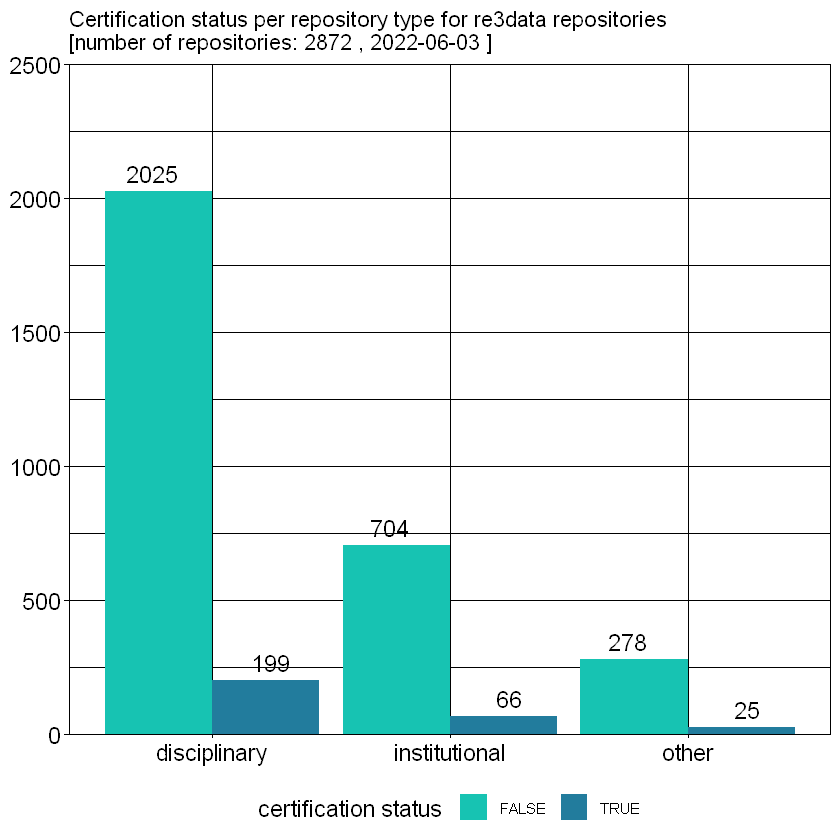

In [8]:
num_repositories <- n_distinct(repository_info$re3data_ID)

repository_info %>%
  filter(!is.na(type)) %>%
  ggplot(aes(x = type, fill = certificate)) +
  geom_bar(position = "dodge") +
  ggtitle(paste("Certification status per repository type for re3data repositories\n[number of repositories:", num_repositories, ",", Sys.Date(), "]")) +
  geom_text(aes(label = ..count..), size = 5, stat = "count", position = position_dodge(width = 1), vjust = -0.5) +
  scale_y_continuous(expand = c(0,0), limits = c(0,2500)) +
  scale_fill_manual(values = c("#17C3B2", "#227C9D")) +
  labs(fill = "certification status") +
  theme_linedraw() +
  theme(axis.title = element_blank(),
        axis.text = element_text(size = 14),
        legend.position = "bottom",
        legend.title = element_text(size = 14))